## Libraries

In [ ]:
import numpy as np, pandas as pd, nltk, spacy, itertools
from matplotlib import pyplot as plt
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Functions

In [ ]:
# Lemmatize and remove stop words
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    doc = nlp(text)
    lemmatized = [token.lemma_ for token in doc if token.text.lower() not in stop_words]
    return ' '.join(lemmatized)

# Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Dataset Exploration

In [2]:
df = pd.read_csv('/kaggle/input/tweets/tweets.csv')
# Rename the columns
df.columns = ['index', 'text', 'label']
df = df.drop('index', axis=1)

# Target variables
Y = df['label']

In [3]:
print(f'There are {len(df)} tweets in the dataset.\n')
# Checking for NaN values,the first .any() checks if there are any True values in each column 
# and the second checks if there is at least one in the resulting Series.
if df.isna().any().any(): 
    print("There are NaN values in the dataset.")
else:
    print("No NaN values in the dataset.")

# Mapping integers to thw corresponding sentiment
mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
sentiments = df['label'].map(mapping)

# Sentiment distribution
print(f'\nSentiments in the dataset:\n{sentiments.value_counts()}')

There are 416809 tweets in the dataset.

No NaN values in the dataset.

Sentiments in the dataset:
label
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


Word Cloud & Token Frequency Plot

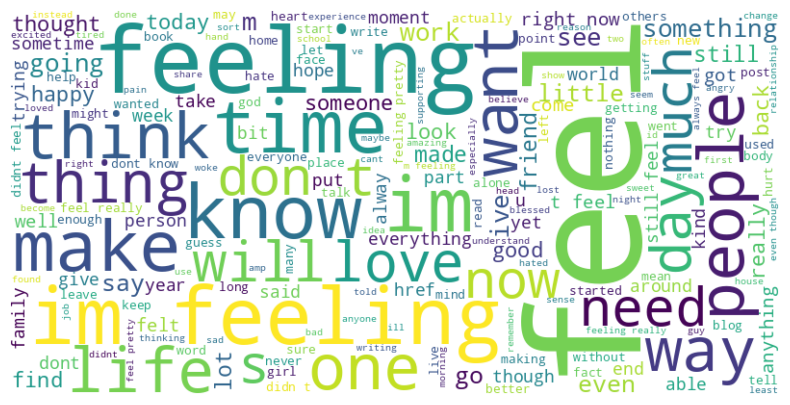

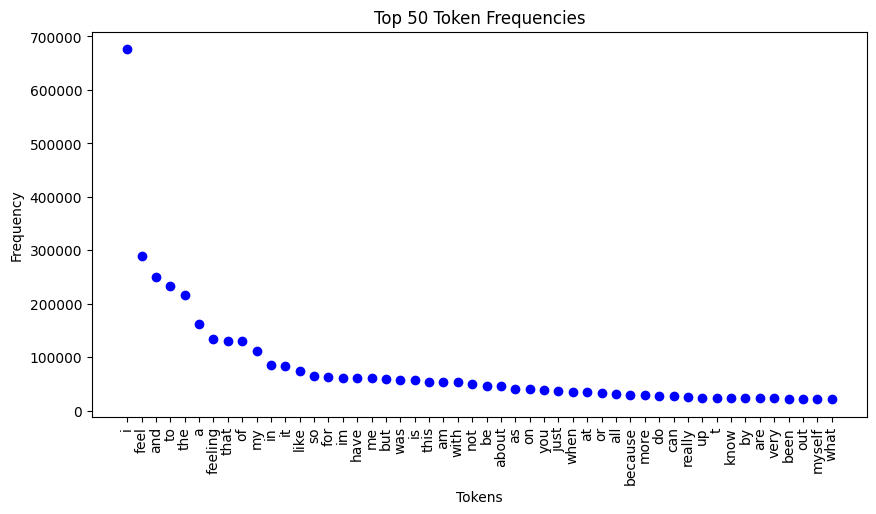

In [4]:
# Generate word cloud
combined_text = ' '.join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)  
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate token frequencies
tokens = word_tokenize(combined_text.lower())
freq_dist = FreqDist(tokens)
top_tokens, top_frequencies = zip(*freq_dist.most_common(50))
plt.figure(figsize=(10, 5))
plt.plot(top_tokens, top_frequencies, marker='o', linestyle='', color='b')
plt.xticks(rotation=90, ha='center')
plt.title("Top 50 Token Frequencies")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

## Text Preprocessing

In [7]:
cleaned_texts = df['text'].apply(text_preprocessing)

# Splitting into training and testing samples
d_train, d_test, Y_train, Y_test = train_test_split(cleaned_texts, Y, test_size=0.10, random_state=42)

## Suppot Vector Machines

In [9]:
X_train, X_test = d_train, d_test

#Support Vector Machines
estimator = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=2000)),
    ('clf', SVC(kernel='linear', class_weight='balanced', random_state=42))
])

In [10]:
estimator.fit(X_train, Y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000, stop_words='english')),
                ('clf',
                 SVC(class_weight='balanced', kernel='linear',
                     random_state=42))])

In [11]:
predictions = estimator.predict(X_test)

report = classification_report(Y_test, predictions, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print("Classification Report for SVM on Test Set:\n", report)

Classification Report for SVM on Test Set:
               precision    recall  f1-score   support

     sadness       0.94      0.87      0.91     12012
         joy       0.95      0.84      0.89     14142
        love       0.68      0.93      0.78      3495
       anger       0.85      0.88      0.87      5667
        fear       0.83      0.86      0.85      4849
    surprise       0.63      0.95      0.75      1516

    accuracy                           0.87     41681
   macro avg       0.81      0.89      0.84     41681
weighted avg       0.89      0.87      0.87     41681



Confusion matrix, without normalization
[[10639   281   148   469   361   114]
 [  270 12030  1267   187   130   258]
 [    9    33  3413    17     6    17]
 [  111   132    44  5107   240    33]
 [   62    31    30   107  4209   410]
 [    3    15     7     5    18  1468]]


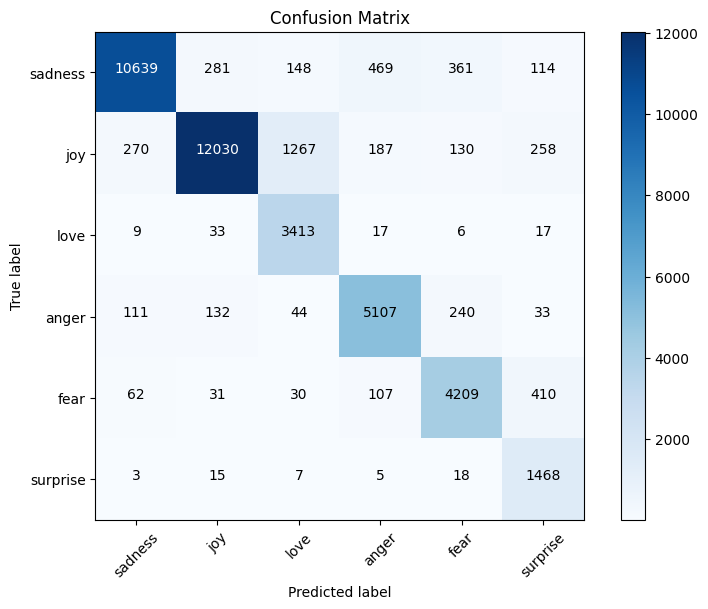

In [ ]:
cm = confusion_matrix(Y_test, predictions)
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_confusion_matrix(cm, classes)

## LSTM

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(d_train)
# Convert text to sequences of integer indices
sequences = tokenizer.texts_to_sequences(d_train)
sequences_test = tokenizer.texts_to_sequences(d_test)
sequence_lengths = [len(seq) for seq in sequences]
average_length = np.mean(sequence_lengths)
percentile_90 = np.percentile(sequence_lengths, 90)
max_length = np.max(sequence_lengths)
print(f"Average Sequence Length: {average_length}")
print(f"90th Percentile: {percentile_90}")
print(f"max length: {max_length}")

Average Sequence Length: 9.167510822972426
90th Percentile: 16.0
max length: 79


In [13]:
# Pad sequences to a consistent length
padded_sequences = pad_sequences(sequences, maxlen=int(percentile_90), padding='post')
padded_sequences_test = pad_sequences(sequences_test, maxlen=int(percentile_90), padding='post')

#Introduce class weigths
class_labels = np.unique(Y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=Y_train)
class_weight_dict = dict(zip(class_labels, class_weights))

vocab_size = len(tokenizer.word_index) + 1

In [14]:
# Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=int(percentile_90)))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
X_train = padded_sequences
model.fit(X_train, Y_train, epochs=10, batch_size=64)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.7984 - loss: 0.5082
Epoch 2/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9195 - loss: 0.1696
Epoch 3/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9260 - loss: 0.1454
Epoch 4/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9297 - loss: 0.1292
Epoch 5/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9338 - loss: 0.1181
Epoch 6/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9356 - loss: 0.1097
Epoch 7/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9378 - loss: 0.1035
Epoch 8/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - accuracy: 0.9386 - loss: 0.0995
Epoch 9/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9404 - loss: 0.0949
Epoch 10/10
5862/5862 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - accuracy: 0.9419 - loss: 0.0925


In [15]:
# Predictions on the test set
predictions = model.predict(padded_sequences_test)
results = list(predictions.argmax(1))
report = classification_report(Y_test, results, target_names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])
print("Classification Report for LSTM on Test Set:\n", report)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Classification Report for LSTM on Test Set:
               precision    recall  f1-score   support

     sadness       0.94      0.96      0.95     12012
         joy       0.96      0.90      0.93     14142
        love       0.74      0.93      0.82      3495
       anger       0.91      0.90      0.91      5667
        fear       0.85      0.89      0.87      4849
    surprise       0.90      0.60      0.72      1516

    accuracy                           0.91     41681
   macro avg       0.88      0.86      0.87     41681
weighted avg       0.91      0.91      0.91     41681



Confusion matrix, without normalization
[[11479   112    51   149   214     7]
 [  155 12761  1074    64    49    39]
 [   39   162  3263    21     5     5]
 [  380    82    26  5090    85     4]
 [  148    65     9   249  4326    52]
 [   25   144     6     6   419   916]]


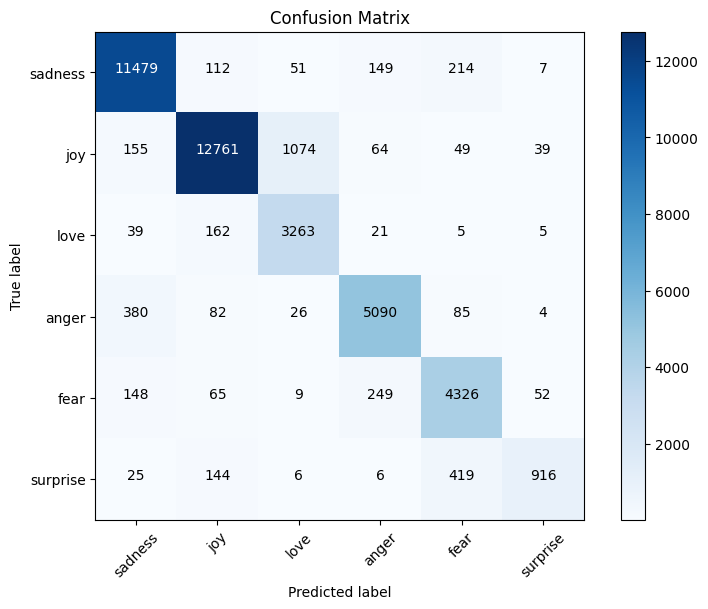

In [16]:
cm = confusion_matrix(Y_test, results)
classes = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_confusion_matrix(cm, classes)